# Pulsed Sources

ZPGenerator is a source-focused simulator that is primarily designed to study realistic states of light produced by a physical source model. In [Photonic Circuits](photonic_circuits.ipynb) tutorial, we explored the Processor class and how to simulate photonic circuits using a few catalogue source types. However, one can imagine that, once a source is no longer perfect, it can be "not perfect" in _many_ different ways. Subtle differences in these photonic imperfections can have quite a big impact on how errors accumulate and impact a quantum information processing task. In addition, often a physical implementation of a source cannot be ideal even in principle. Thus, a key goal is to optimise the source parameters to accomplish a particular task most effectively. For these reasons, the second main functionality provided by ZPGenerator is the characterisation of pulsed sources of quantum light.

In [42]:
from zpgenerator import *
import numpy as np
import matplotlib.pyplot as plt

## Fock states

A SourceComponent object, such as those created using the Source class, have built-in methods that can be useful to characterise source behaviour. Let's first dig deeper into the Fock state source used in the previous section. The first thing we can check are the photon number probabilities of the source using the photon_statistics() method. This method produces a PhotonNumberDistribution object.

In [43]:
source = Source.fock(1)
pn = source.photon_statistics()
pn.display()

Number  | Probability
0       | 0.00000
1       | 1.00000
2       | 0.00000
3       | 0.00000
4       | 0.00000



With this distribution, we now have access to methds that compute other characteristics, such as the average photon number $\mu$, the probability of emitting at least one photon $\beta$, and the integrated intensity correlation $g^{(2)}$. This can be done using the mu(), beta(), and g2() methods.

In [44]:
print({'mu': pn.mu(), 'beta': pn.beta(), 'g2': pn.g2()})

{'mu': 1.0, 'beta': 1.0, 'g2': 0.0}


Or, we can use display_figures() to automatically compute them and display them.

In [45]:
pn.display_figures()

Figure of Merit       | Value
Brightness            | 1.0000
Average photon number | 1.0000
Intensity correlation | 0.0000



As expected, our source of perfect $|1\rangle$ states produces an average photon number $\mu$ of $1$, a probability of emitting at least one photon $\beta$ of $1$, and an integrated intensity correlation $g^{(2)}$ of $0$. This is due to the fact that the photon number distribution is $p_1=1$.

We can also evaluate basic figures of merit that cannot be obtained from the photon number distribution by performing Hong-Ou-Mandel interference of the wavepacket with itself using the hom() method. We _could_ manually build the interferometer as in the previous section, but since this is such a common circuit to simulate, it is integrated into the Processor class.

In [46]:
source.hom()

{'c1': 0.0, 'c2': 0.0, 'vhom': 1.0000006344860717, 'M': 1.000002776951858}

Like for the other figures of merit, we can compute and display them using the display_hom() method.

In [47]:
source.display_hom()

Figure of Merit                | Value
First order number coherence   | 0.0000
Second order number coherence  | 0.0000
Hong-Ou-Mandel visibility      | 1.0000
Mean wavepacket overlap        | 1.0000



Applying the vhom() method computes additional important source figures of merit: the Hong-Ou-Mandel visibility $V_\text{HOM}$, the mean wavepacket overlap $M$, the first-order number coherence $c^{(1)}$, and the second-order number coherence $c^{(2)}$. As expected, we find $V_\text{HOM}=M=1$ and $c^{(1)}=c^{(2)}=0$, characteristic of a single-photon Fock state. 

Another important characteristic of a pulsed source of light is its temporal profile: how the wavepacket intensity evolves in time. In the context of deterministic sources of quantum light, this is often referred to as the "lifetime" of the wavepacket because it reflects the decay dynamics of the source excited state population quantified by the lifetime timescale $T_1$. In fact, all parameters in ZPG are, by default, in units of this decay timescale $T_1$. The Source class provides the lifetime() method to simulate the temporal profile.

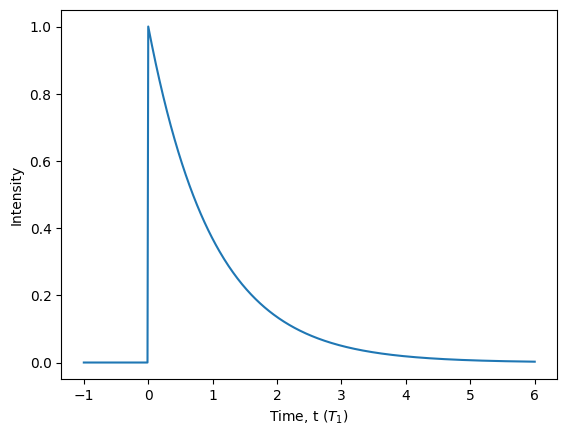

In [48]:
# we can use the 'start' and 'end' keywords to specify the window of time to look at (in units of T1)
lifetime = source.lifetime(start=-1, end=6)
plt.plot(lifetime.times, lifetime.population)
plt.xlabel('Time, t ($T_1$)')
plt.ylabel('Intensity')
plt.show()

From the above plot, we can see that the Fock state source actually produces photons with an exponentially decaying temporal shape. This is because it is the simplest shape to simulate using the ZPG backend, which is also very close to the profile of the emission from a quickly-excited atom or quantum dot. This differs substantially from how Perceval models a Fock state $|1\rangle$ source as an abstract complex vector. In ZPGenerator, the single photon is a physical object evolving in time with quantum properties dictated by its source. This allows the framework to capture various subtle characteristics of light produced by many different physical source models.

## Physical models

In reality, the excitation of the source can never be perfectly instantaneous. This limitation is the primary reason for incidental multi-photon emission when attempting to generate single photons. To dig deeper into the physics, we can take a look at a more realistic pre-built source model: the two-level() source. This source is a two-level system driven by a dirac laser pulse by default so that it behaves like a perfect single-photon source. Using the Pulse() class, we can set a new pulse shape for our two-level source. Let's use a square pulse with a width of $1/2$ the source lifetime, and then take a look at the lifetime, and plot the control pulse alongside for comparison.

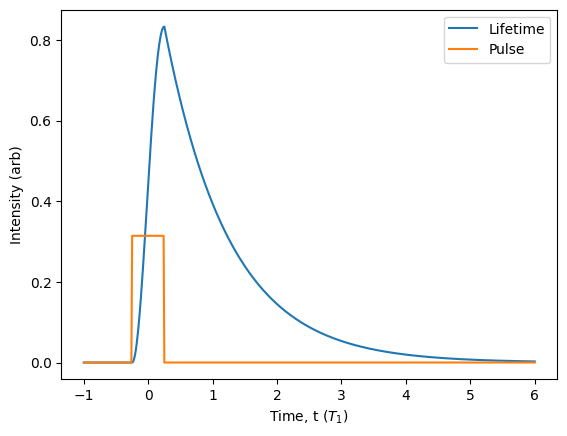

In [49]:
pulse = Pulse.square(parameters={'width': 0.5})
source = Source.two_level(pulse=pulse)
lifetime = source.lifetime(start = -1, end = 6)
plt.plot(lifetime.times, lifetime.population, label = 'Lifetime')

# 1/20 for visual comparison
pulse = [abs(pulse.evaluate(t)) / 20 for t in lifetime.times]
plt.plot(lifetime.times, pulse, label = 'Pulse')

plt.xlabel('Time, t ($T_1$)')
plt.ylabel('Intensity (arb)')
plt.legend()
plt.show()

Let's also take a look at all figures of merit by using the display_quality() method.

In [50]:
source.display_quality()

Number  | Probability
0       | 0.00560
1       | 0.94076
2       | 0.05319
3       | 0.00044
4       | 0.00000

Figure of Merit       | Value
Brightness            | 0.9944
Average photon number | 1.0485
Intensity correlation | 0.0992

Figure of Merit                | Value
First order number coherence   | 0.0784
Second order number coherence  | 0.0023
Hong-Ou-Mandel visibility      | 0.8108
Mean wavepacket overlap        | 0.9096



We can now clearly see how the imperfect excitation pulse affects both the shape of our photon, and its key figures of merit. Most importantly, the finite pulse width causes a significant two-photon emission probability of $p_2=0.05$, which for $\mu$ near $1$ gives us $g^{(2)} = 0.1$. This non-unity single photon purity drastically reduces the Hong-Ou-Mandel visibility down to $V_\text{HOM} = 0.8$. Note that here, there is no pure dephasing at all! The reduction in visibility is only due to multi-photon emission.

Using the methods available in the Processor class to analyze sources, it is straightforward to compute how figures of merit depend on control parameters, such as the pulse power (pulse area) of the excitation pulse. For this, we can take advantage of the fact that all evaluated figures of merit are automatically stored in the 'quality' property of the processor. However, since a processor may have more than one output mode, the processor 'quality' is a dictionary that stores the figures of merit for each output mode. Since we have a source with a single output mode, we must ask for mode '0'. In addition, since we will update this dictionary with every new parameter, we must copy the result to avoid mutating the dicationary from previous evaluations.

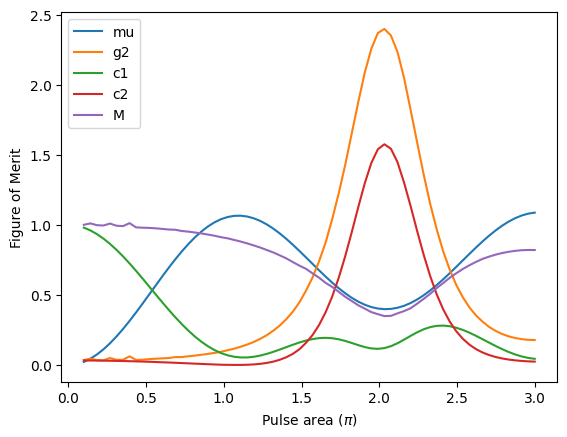

In [51]:
def quality(area: float = np.pi): # Make a function to generate the figures of merit for a given pulse area
    source.hom(parameters={'area': area},
               pseudo_limit=0.01,
               update_mu = True, update_g2 = True)  # we can ask hom() to also compute mu and g2 (saves some time)
    return source.quality['0'].copy()  # we return a copy of the dictionary of current stored figures of merit of mode '0' from quality

areas = np.linspace(0.1, 3, 70)  # make a list of pulse areas to evaluate
quality_set = [quality(area * np.pi) for area in areas]  # evaluate the source quality

foms = ['mu', 'g2', 'c1', 'c2', 'M']  # Now, let's plot the figures of merit!
for fom in foms:
    plt.plot(areas, [q[fom] for q in quality_set], label = fom)
plt.xlabel('Pulse area ($\pi$)')
plt.ylabel('Figure of Merit')
plt.legend(loc = 'upper left')
plt.show()

In this plot, we can see a plethora of interesting physical results produced with just a few lines of code. The average photon number undergoes a Rabi oscillation that is dampened by the emission of photons [[T. H. Stievater et al., Phys. Rev. Lett. 87, 133603 (2001)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.87.133603)]. Near the first peak of the Rabi oscillation, we are driving with a pulse area of $\pi$, usually referred to as a '$\pi$-pulse'. This is the point that produces light close to an ideal single photon. In essence, this is the point where the pulse performs a 'bit flip' gate on the two-level system. In the case above, our pulse is quite slow, so we see a lot of degradation of the source quality.

We can also see the well-known spike in $g^{(2)}$ at $2\pi$ [[K. A. Fischer et al., Nature Physics 13, 649–654 (2017)](https://www.nature.com/articles/nphys4052)], and the increase in $c^{(1)}$ as the pulse area approaches zero [[I. Maillette de Buy Wenniger et al., Phys. Rev. Lett. 131, 260401 (2023)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.131.260401)]. Additionally, we can see that $c^{(2)}$ follows $g^{(2)}$ and shows a spike at $2\pi$ similar to results in this work [[S. C. Wein, Nature Photonics 16, 374–379 (2022)](https://www.nature.com/articles/s41566-022-00979-z)], while the mean wavepacket overlap $M$ is decreased due to the increase in $g^{(2)}$. This relationship between $M$ and $g^{(2)}$ can be quite complicated, and was the subject of this paper [[H. Ollivier et al., Phys. Rev. Lett. 126, 063602 (2021)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.063602)].

## Excitation pulses

Often times, a realistic laser pulse is modelled by a Gaussian function rather than a square function. We can build our two-level source using a different pulse shape if we wish. This is again accomplished using the Pulse class.

To quickly visualize what is happening, we can use the plot() method of the Pulse class along with the plot_lifetime() method of the Source class.

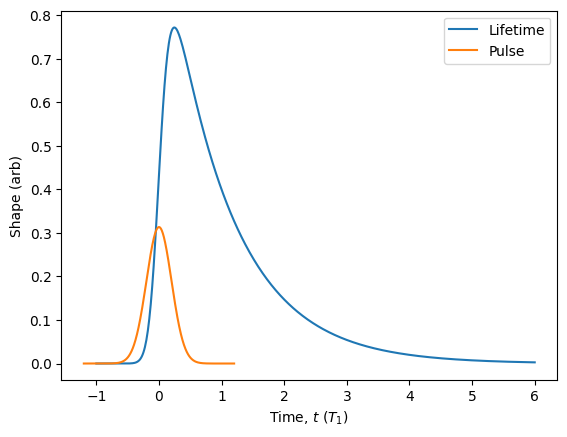

In [52]:
pulse = Pulse.gaussian({'width': 0.2, 'window': 6})
source = Source.two_level(pulse=pulse)

source.plot_lifetime(start = -1, end = 6, label='Lifetime')
pulse.plot(scale=1/20).show()  # We can scale down the pulse for better visualisation

ZPGenerator is designed to simulate sources of light that may rely on complicated pulse sequences. Building these pulse sequences can be done in an intuitive way using the Pulse class. We can simply initialise a Pulse object and then use the add() method to append new pulse objects to it. We can also add different kinds of pulses to the same sequence. Once we are done, we create a source that uses that pulse sequence.

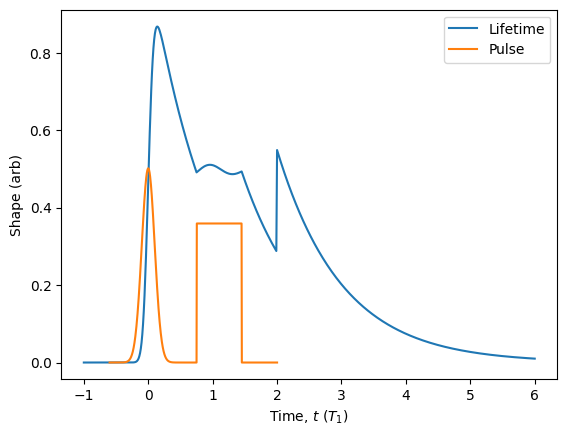

In [53]:
sequence = Pulse()
sequence.add(Pulse.gaussian({'delay': 0}))
sequence.add(Pulse.square({'delay': 1.1, 'width': 0.7, 'area': 2*np.pi}))
sequence.add(Pulse.dirac({'delay': 2, 'area': np.pi/2}))

source = Source.two_level(pulse=sequence)
source.plot_lifetime(start = -1, end = 6, label='Lifetime')
sequence.plot(scale=1/25).show()  # notice that dirac pulses are not plotted!

## Custom shapes

In addition to the built-in Dirac, Gaussian, and square pulses, the Pulse class has the custom() class method to automate the construction of custom parameterised pulses. For example, we can make a quadratic pulse by giving it a function that takes two arguments t: float and args: dict. The interval for the pulse is specified using a list of two values or a function of args: dict that returns a list of two values. Finally, we must also specify any default parameters for the shape and gate, otherwise the initialisation will fail.

To demonstrate, let's make a quadratic pulse function.

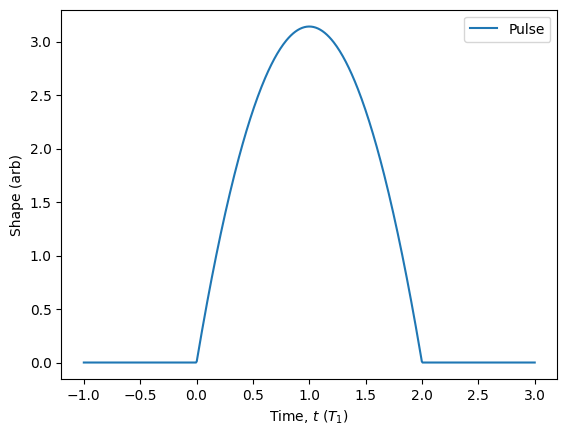

In [54]:
my_pulse = Pulse.custom(shape=lambda t, args: args['area'] * (1 - (t - args['delay'])**2),
                        gate=lambda args: [args['delay'] - 1, args['delay'] + 1],
                        parameters={'area': np.pi, 'delay': 0})
my_pulse.plot(parameters={'delay': 1}, start=-1, end=3).show()

We can check to see that the shape has not been normalised correctly.

In [55]:
my_pulse.area(parameters={'area': 1})

1.3333333333333333

Either we can ensure that the function we input is normalised, or we can use some options to automatically normalise the shape to a specified default value before building the pulse. Since we are scaling the function by the parameter 'area', we simply provide the default value for 'area' as the required norm.

In [56]:
my_pulse = Pulse.custom(shape=lambda t, args: args['area'] * (1 - (t - args['delay'])**2),
                        gate=lambda args: [args['delay'] - 1, args['delay'] + 1],
                        parameters={'area': np.pi, 'delay': 0},
                        auto_normalise=True,
                        norm=np.pi,
                        name='Quadratic pulse')
my_pulse.area({'area': 1}) == 1

True

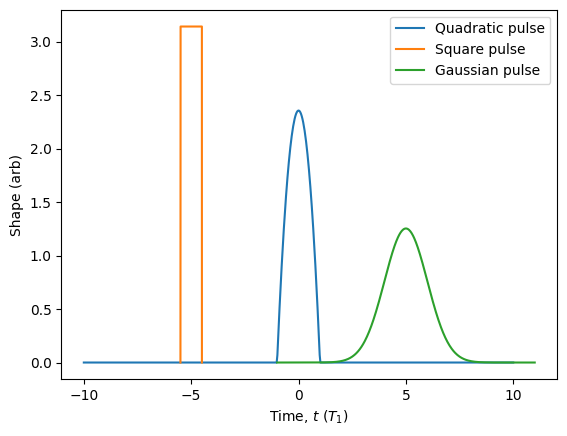

In [57]:
my_pulse.plot(start=-10, end=10)
Pulse.square(name='Square pulse').plot(parameters={'width': 1, 'delay': -5})
Pulse.gaussian(name='Gaussian pulse').plot(parameters={'width': 1, 'delay': 5}).show()

Once we have defined our custom pulse, we can create our source and look at the lifetime and figures of merit.

Number  | Probability
0       | 0.04115
1       | 0.84480
2       | 0.11136
3       | 0.00267
4       | 0.00002

Figure of Merit       | Value
Brightness            | 0.9588
Average photon number | 1.0756
Intensity correlation | 0.2066

Figure of Merit                | Value
First order number coherence   | 0.2602
Second order number coherence  | 0.0261
Hong-Ou-Mandel visibility      | 0.6446
Mean wavepacket overlap        | 0.8514



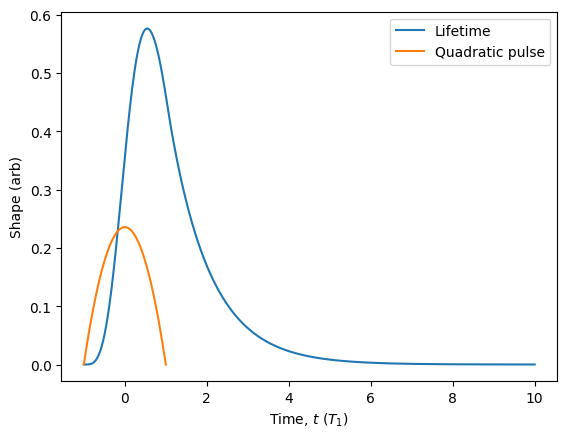

In [58]:
source = Source.two_level(pulse=my_pulse)
source.display_quality()
source.plot_lifetime(end = 10, label='Lifetime')
my_pulse.plot(scale=1/10).show()

Looks like the quadratic pulse gives some bad multi-photon emission! To mitigate this, we can narrow the pulse by adding a 'width' parameter to our custom pulse. In this case, we have to be careful to normalise by the width parameter so that the integrated area remains constant as a function of the width.

In [59]:
my_pulse = Pulse.custom(shape=lambda t, args: args['area'] / args['width'] *
                                              (1 - (t / args['width'] - args['delay'])**2),
                        gate=lambda args: [args['delay'] - args['width'], args['delay'] + args['width']],
                        parameters={'area': np.pi, 'delay': 0, 'width': 1},
                        auto_normalise=True,
                        norm=np.pi,
                        name='pulse')

Number  | Probability
0       | 0.00220
1       | 0.96501
2       | 0.03262
3       | 0.00017
4       | 0.00000

Figure of Merit       | Value
Brightness            | 0.9978
Average photon number | 1.0308
Intensity correlation | 0.0624

Figure of Merit                | Value
First order number coherence   | 0.0434
Second order number coherence  | 0.0007
Hong-Ou-Mandel visibility      | 0.8792
Mean wavepacket overlap        | 0.9416



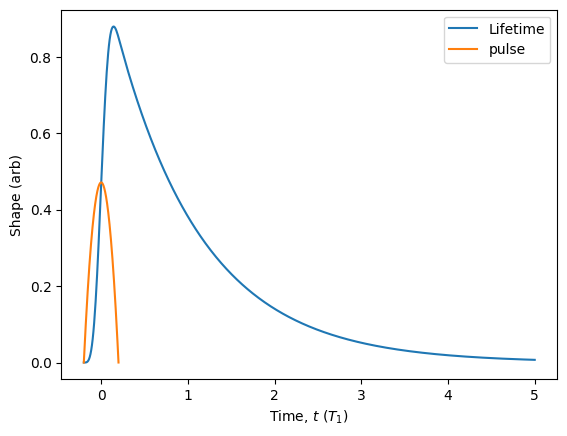

In [60]:
my_pulse.update_default_parameters(parameters={'width': 0.2})
source = Source.two_level(pulse=my_pulse)
source.display_quality()
source.plot_lifetime(end = 5, label='Lifetime')
my_pulse.plot(scale=1/25).show()